In [50]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
#from keras.layers import Dense, Embedding, LSTM, SimpleRNN, SpatialDropout1D
from keras.layers import Dense, Activation, Flatten
from keras.layers import Dropout
from sklearn.model_selection import train_test_split
from sklearn import metrics
from keras.wrappers.scikit_learn import KerasClassifier
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.layers import Embedding, LSTM, Dense, SpatialDropout1D, Bidirectional, Conv1D, GlobalMaxPool1D

In [51]:
data = pd.read_csv("/content/FinalDatasetmerged (1).csv")
data.head(2)

,content,sentiment_labels
0,feature search hotspot location able function ...,-1.0
1,good,2.0


In [52]:
data=data.dropna()
data.shape

(32183, 2)

In [53]:
!pip install keras.utils 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [54]:
data["sentiment_labels"].replace({-1: 0}, inplace=True)
data['sentiment_labels'].unique()

array([0., 2., 1.])

In [55]:
from tensorflow.keras.utils import to_categorical
labels = to_categorical(data['sentiment_labels'], num_classes=3)
labels.shape
#labels = data['label'].values
#labels

(32183, 3)

In [56]:
max_features = 10000 #Max Num Words
max_len = 300 #Max Input Length #100
token = Tokenizer(num_words=max_features)
token.fit_on_texts(data['content'].values)
sequences = token.texts_to_sequences(data['content'].values)
X = pad_sequences(sequences, maxlen=max_len)#.reshape(-1,1)
word_index = token.word_index
print('Found %s unique tokens.' % len(word_index))

Found 13961 unique tokens.


In [57]:
y = labels#.reshape(-1,1)
y.shape,X.shape

((32183, 3), (32183, 300))

In [58]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.20)

tuning_results.best_params_:-
{'batch_size': 128,
 'embed_dim': 100,
 'epochs': 5,
 'lstm_dropout': 0.2,
 'optimizer': 'adam',
 'spatial_dropout': 0.3}

In [59]:
ls_model = Sequential()
ls_model.add(Embedding(max_features, 100, input_length = X.shape[1]))
#ls_model.add(SpatialDropout1D(spatial_dropout))
ls_model.add((LSTM(100, dropout=0.2, recurrent_dropout=0.2,return_sequences=True)))
ls_model.add(Flatten())
ls_model.add(Dense(3, activation='softmax'))# Dense layers improve overall accuracy and 5–10 units or nodes per layer is a good base.
ls_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])
ls_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 300, 100)          1000000   
                                                                 
 lstm_2 (LSTM)               (None, 300, 100)          80400     
                                                                 
 flatten_2 (Flatten)         (None, 30000)             0         
                                                                 
 dense_2 (Dense)             (None, 3)                 90003     
                                                                 
Total params: 1,170,403
Trainable params: 1,170,403
Non-trainable params: 0
_________________________________________________________________


What is early stopping mode?
mode: One of {"auto", "min", "max"} . In min mode, training will stop when the quantity monitored has stopped decreasing; in "max" mode it will stop when the quantity monitored has stopped increasing; in "auto" mode, the direction is automatically inferred from the name of the monitored quantity.

In [60]:
#batch_size = 128     #130#256#64
#ms_history = ls_model.fit(X_train, y_train,epochs=10, batch_size=batch_size,verbose = 2)
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
# ls_model.fit(X_train, y_train, epochs=7, batch_size=128, class_weight=None,
#                 callbacks= [ModelCheckpoint('lstm_model.hyp', monitor='loss', #lstm_model.hyp for 10epoch
#                                             verbose=1, save_best_only=True)], 
#                 verbose=2)
earlyStop=EarlyStopping(monitor="val_loss",verbose=2,mode='max',patience=3)
history=ls_model.fit(X_train,y_train,epochs=7,batch_size=128,validation_data=(X_test,y_test) ,verbose=2,callbacks=[earlyStop])

Epoch 1/7
202/202 - 317s - loss: 0.5454 - acc: 0.7777 - val_loss: 0.2443 - val_acc: 0.9236 - 317s/epoch - 2s/step
Epoch 2/7
202/202 - 279s - loss: 0.1966 - acc: 0.9366 - val_loss: 0.2246 - val_acc: 0.9253 - 279s/epoch - 1s/step
Epoch 3/7
202/202 - 277s - loss: 0.1432 - acc: 0.9546 - val_loss: 0.2250 - val_acc: 0.9279 - 277s/epoch - 1s/step
Epoch 4/7
202/202 - 280s - loss: 0.1154 - acc: 0.9635 - val_loss: 0.2393 - val_acc: 0.9318 - 280s/epoch - 1s/step
Epoch 4: early stopping


In [61]:
loss, accuracy = ls_model.evaluate(X_test, y_test)
print("loss", loss)
print("accuracy", accuracy)

202/202 [==============================] - 34s 166ms/step - loss: 0.2393 - acc: 0.9318
loss 0.23934710025787354
accuracy 0.9318005442619324


In [85]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix
pred = ls_model.predict(X_test)
labels = ['Negative', 'Neutral', 'Positive']
y_pred_labels = [labels[x] for x in [np.argmax(x) for x in pred]]
y_test_labels = [labels[x] for x in [np.argmax(x) for x in y_test]]
confusion = confusion_matrix(y_test_labels, y_pred_labels)
confusion_df = pd.DataFrame(confusion,index=[labels], columns=[labels])
print(confusion_df)

         Negative Neutral Positive
Negative     1876      23       95
Neutral        55     892      116
Positive       64      86     3230


[Text(0, 0.5, 'NEGATIVE'), Text(0, 1.5, 'NEUTRAL'), Text(0, 2.5, 'POSITIVE')]

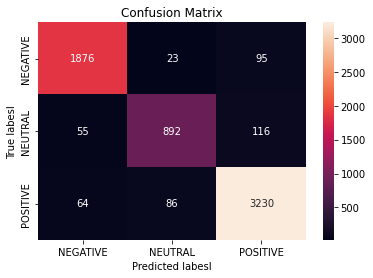

In [84]:
import matplotlib.pyplot as plt
import seaborn as sns
ax = plt.subplot()
sns.heatmap(confusion_df,annot=True, fmt='g',ax=ax)
ax.set_xlabel('Predicted labesl')
ax.set_ylabel('True labesl')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(['NEGATIVE','NEUTRAL', 'POSITIVE'])
ax.yaxis.set_ticklabels(['NEGATIVE','NEUTRAL', 'POSITIVE'])

In [83]:
from sklearn import metrics
print(metrics.classification_report(y_test_labels,y_pred_labels))

              precision    recall  f1-score   support

    Negative       0.94      0.94      0.94      1994
     Neutral       0.89      0.84      0.86      1063
    Positive       0.94      0.96      0.95      3380

    accuracy                           0.93      6437
   macro avg       0.92      0.91      0.92      6437
weighted avg       0.93      0.93      0.93      6437



In [65]:
#text = ['i would recommend it if you have no other options']
#text = ['Wont let me update or scan most QR codes']
text = ['Not using the app is better']
text = token.texts_to_sequences(text)
text = pad_sequences(text, maxlen=max_len)
res = ls_model.predict(text)
res

array([[9.111118e-01, 8.167783e-04, 8.807141e-02]], dtype=float32)

In [66]:
if np.argmax(res) == 1:
    print("neutral Comment")
elif np.argmax(res) == 0:
    print("Negetive Comment")
elif np.argmax(res) == 2:
    print("positive Comment")

Negetive Comment


In [67]:
ls_model.save("/content/drive/MyDrive/NZ data/lstm_model.hyp1")

INFO:tensorflow:Assets written to: /content/drive/MyDrive/NZ data/lstm_model.hyp1/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/NZ data/lstm_model.hyp1/assets


In [68]:
from numpy import loadtxt
from keras.models import load_model
# load model
model = load_model("/content/drive/MyDrive/NZ data/lstm_model.hyp1")

In [69]:
nzreview = pd.read_csv("/content/drive/MyDrive/NZ data/nz_review_clened.csv")
#nzreview = nzreview.drop(['Rating'],axis=1)
nzreview.head(2)

,Unnamed: 0,Unnamed: 0.1,Date,Content,Rating,Version,final_text
0,0,0,1/10/2022,Waste of time,1.0,6.0.0,waste time
1,1,1,1/10/2022,Won't let me update or scan most QR codes,1.0,6.0.0,wo let update scan qr codes


In [70]:
nzreview.final_text=nzreview.final_text.astype(str)
text = list(nzreview['Content'])
text = token.texts_to_sequences(text)
text = pad_sequences(text, maxlen=max_len)
#res = ls_model.predict(text)
predict_x=model.predict(text)
classes_x=np.argmax(predict_x,axis=1)
print(classes_x)

[0 0 2 ... 0 2 0]


In [71]:
nzreview['predicted_label'] = classes_x.tolist()
nzreview.head()

,Unnamed: 0,Unnamed: 0.1,Date,Content,Rating,Version,final_text,predicted_label
0,0,0,1/10/2022,Waste of time,1.0,6.0.0,waste time,0
1,1,1,1/10/2022,Won't let me update or scan most QR codes,1.0,6.0.0,wo let update scan qr codes,0
2,2,2,1/10/2022,Does what is expected.,5.0,6.1.0,expected,2
3,3,3,1/10/2022,App is super helpful and anyone that says othe...,5.0,6.1.0,app super helpful anyone says otherwise little...,2
4,4,4,1/10/2022,It's ok. The only thing I find annoying is it ...,4.0,6.1.0,ok thing find annoying keep record places defi...,0


In [72]:
# convert Sentiments to 0,1,2
def convert_Sentiment(sentiment):
    if  sentiment == 2:
        return 'Positive'
    elif sentiment == 1:
        return 'Neutral'
    elif sentiment == 0:
        return 'Negative'

In [73]:
# Apply convert_Sentiment function
nzreview['predicted_label_name'] = nzreview.predicted_label.apply(lambda x : convert_Sentiment(x))
nzreview.tail(100)

,Unnamed: 0,Unnamed: 0.1,Date,Content,Rating,Version,final_text,predicted_label,predicted_label_name
4033,4033,457,8/12/2020,Downloaded app early and easily. Not simple to...,4.0,1.2.0,downloaded app early easily simple use option ...,0,Negative
4034,4034,458,8/12/2020,"Sorry team, you need to do better if you want ...",1.0,1.2.0,sorry team need better want people use tried s...,0,Negative
4035,4035,459,8/12/2020,Rubbish canât even login as keyboard doesnâ...,1.0,1.2.0,rubbish even login keyboard pop email code sen...,0,Negative
4036,4036,460,8/12/2020,"I downloaded the app, entered my email and cre...",1.0,1.2.0,downloaded app entered email created long pass...,0,Negative
4037,4037,461,8/12/2020,When I sign up within the app it tells me I ha...,1.0,1.2.0,sign within app tells already registered email...,0,Negative
...,...,...,...,...,...,...,...,...,...
4128,4128,553,7/21/2020,This app is excellent and very easy to use. I ...,5.0,1.1.0,app excellent easy use feel assured recording ...,2,Positive
4129,4129,554,7/20/2020,Be great if I could go and add a location if I...,4.0,1.1.0,great could go add location forgot scan ie mor...,2,Positive
4130,4130,555,7/16/2020,My App is a bit shonky no longer allows me to ...,1.0,1.1.0,app bit shonky longer allows update details go...,0,Negative
4131,4131,556,7/15/2020,I donât know how many times Iâve tried to ...,1.0,1.1.0,know many times tried scan something says covi...,2,Positive


In [74]:
nzreview['predicted_label_name'].value_counts()

Negative    2630
Positive    1446
Neutral       57
Name: predicted_label_name, dtype: int64

In [75]:
# convert ratings to positive, negative, neutral
def convert_Rating(Rating):
    if  Rating == 5 :    
        return 'Positive'
    if  Rating == 4 :    
        return 'Positive'
    elif Rating ==  3 :
        return 'Neutral'
    elif Rating == 2 :
        return 'Negative'
    elif Rating == 1 :
        return 'Negative'

# Apply convert_Sentiment function
nzreview['Rating_converted']= nzreview.Rating.apply(lambda x : convert_Rating(x))
nzreview.head()

,Unnamed: 0,Unnamed: 0.1,Date,Content,Rating,Version,final_text,predicted_label,predicted_label_name,Rating_converted
0,0,0,1/10/2022,Waste of time,1.0,6.0.0,waste time,0,Negative,Negative
1,1,1,1/10/2022,Won't let me update or scan most QR codes,1.0,6.0.0,wo let update scan qr codes,0,Negative,Negative
2,2,2,1/10/2022,Does what is expected.,5.0,6.1.0,expected,2,Positive,Positive
3,3,3,1/10/2022,App is super helpful and anyone that says othe...,5.0,6.1.0,app super helpful anyone says otherwise little...,2,Positive,Positive
4,4,4,1/10/2022,It's ok. The only thing I find annoying is it ...,4.0,6.1.0,ok thing find annoying keep record places defi...,0,Negative,Positive


In [76]:
nzreview['check'] = np.where(nzreview["predicted_label_name"] == nzreview["Rating_converted"], True, False)

In [77]:
nzreview['check'].value_counts()

True     2845
False    1288
Name: check, dtype: int64

In [78]:
nzreview['check'].value_counts(normalize=True)

True     0.688362
False    0.311638
Name: check, dtype: float64

In [79]:
#nzreview.to_csv('/content/drive/MyDrive/NZ data/nzpredicted_DL.csv')
nzreview.to_csv('/content/nzpredicted_DL2.csv')